# price analysis

This notebook is a price analysis of the listings that name parks in their posts and how they compare to the median gross rent in that area. To find this, we are going to compare listing proces to the median gross rent in the census tract is in.

## step one: data cleaning
### listings
1. Load the listing data from the sorting notebook 
2. Convert listings into a geodataframe using lat/long points
3. Find the price per bedroom for each unit
4. Spatially join listings to a census tract map to assign a census tract to each listing
> - load in census tract data from the LA GeoData Hub
> - create a fips code column for each tract that matches the format of median income data (used later on)
> - join the listings data to the census tracts on the "fip" code column
5. Create a column with a control_price is that lists the cost for one bedroom in each apartment 

In [406]:
import geopandas as gpd
import pandas as pd
from shapely import wkt

listings = pd.read_pickle('listings_sorted.pkl')

In [407]:
listings = gpd.GeoDataFrame(listings, geometry=gpd.points_from_xy(listings.long, listings.lat), crs="EPSG:4326")

In [408]:
tracts = gpd.read_file('Census_Tracts_2020.geojson')
tracts['fip'] = '6037'+tracts['CT20']
tracts['fip'] = tracts['fip'].astype('int')

In [409]:
cols = ['geometry','fip']
tracts = tracts[cols]

In [410]:
listings_tracts = gpd.sjoin(listings, tracts[['fip','geometry']], predicate='intersects')
listings_tracts.drop('index_right', axis=1, inplace=True)

In [411]:
import numpy as np

listings_tracts['price_control'] = np.where(listings_tracts['bedrooms'] == 0, listings_tracts['price'] / 1, 
                                            listings_tracts['price'] / listings_tracts['bedrooms'])
pd.reset_option('max_colwidth')
listings_tracts.sample(2)

,urls,price,description,lat,long,bedrooms,bathrooms,sqft,park_TF,park_T_why,geometry,fip,price_control
7078,https://losangeles.craigslist.org/wst/apa/d/lo...,4210.0,located near the scenic west los angeles neigh...,34.066000,-118.474000,2.0,2.0,1300.0,False,[],POINT (-118.47400 34.06600),6037262302,2105.0
7970,https://losangeles.craigslist.org/wst/apa/d/lo...,1900.0,location between pico and venice two blocks ea...,34.046429,-118.305308,1.0,1.0,NaN,False,[],POINT (-118.30531 34.04643),6037221303,1900.0


### start to parse differences
6. Seperate listings into two dataframes
> - one of listings that mention parks "parks_true" 
> - one of listings that don't mention parks "parks_false"
7. Find the median rent for listings in each census tract in both dataframes
8. Find the average rent for listings in each census tract in both dataframes
9. Create a dataframe organized by census tract with the median and average rent for one bedroom in each the tract as well as the median and average rent for one bedroom in apartments that list park and those that don't. 

In [412]:
parks_true = listings_tracts[listings_tracts['park_TF'] == True]
parks_false = listings_tracts[listings_tracts['park_TF'] == False]

In [413]:
total_med = listings_tracts.groupby('fip')['price_control'].median()
parks_true_med = parks_true.groupby('fip')['price_control'].median()
parks_false_med = parks_false.groupby('fip')['price_control'].median()

In [414]:
total_average = listings_tracts.groupby('fip')['price_control'].mean()
parks_true_average = parks_true.groupby('fip')['price_control'].mean()
parks_false_average = parks_false.groupby('fip')['price_control'].mean()

In [415]:
total_med.name = 'median_rent_tot'
parks_true_med.name = 'median_rent_PM'
parks_false_med.name = 'medain_rent_PNM'
total_average.name = 'average_rent_tot'
parks_true_average.name = 'average_rent_PM'
parks_false_average.name = 'average_rent_PNM'

In [423]:
price_df = pd.DataFrame(total_med)
price_df = price_df.join(total_average)
price_df = price_df.join(parks_true_med)
price_df = price_df.join(parks_false_med)
price_df = price_df.join(parks_true_average)
price_df = price_df.join(parks_false_average)
price_df.sample(2)

,median_rent_tot,average_rent_tot,median_rent_PM,medain_rent_PNM,average_rent_PM,average_rent_PNM
fip,,,,,,
6037209202,1395.0,1363.333374,NaN,1395.0,NaN,1363.333374
6037207305,1950.0,1947.333374,2166.5,1950.0,2162.625,1917.637939


 ### compare with other median rent data
10. Load census tract gross median rent prices from USC database
> - filter to just look at 2021 
11. adjust for inflation! I used the US census calculator to find the inflation from 2021 and 2023 - 15.97% and multiplied the median rent price from 2021 by 1.1597 to find what the median rent in 2021 would translate to in the 2023 dollar.
12. join the adjusted median gross rent data to the listing price data.
11. drop null values from prices
12. add the census tract geometry to the new listings dataframe using the merge function so we can map these when we want to. 

In [424]:
median_rent = pd.read_csv('All Years Median Gross Rent Calculations.csv')
median_rent = median_rent[median_rent['year'] == 2021]
median_rent.sample(2)

,geoid,geoid20,year,denom_renters,med_gross_rent,med_gross_rent_adj
2030,1400000US06037576402,6037576402,2021,1070.0,1410.0,1476.4684
863,1400000US06037238200,6037238200,2021,1279.0,1079.0,1129.8649


In [425]:
median_rent['adjust_2023'] = median_rent['med_gross_rent']*1.1597

In [426]:
col = ['geoid20','med_gross_rent','adjust_2023']

In [427]:
median_rent = median_rent[col]
median_rent.rename(columns={'geoid20':'fip'}, inplace=True)
median_rent['fip'] = median_rent['fip'].astype('int')

In [432]:
prices = median_rent.join(price_df, on='fip')

In [433]:
prices = prices.dropna()

In [434]:
df  = prices.merge(tracts, on='fip', how='left')
df.sample(2)

,fip,med_gross_rent,adjust_2023,median_rent_tot,average_rent_tot,median_rent_PM,medain_rent_PNM,average_rent_PM,average_rent_PNM,geometry
178,6037267300,1841.0,2135.0077,1957.5,2078.322266,2222.0,1957.5,2316.666748,2056.208008,"POLYGON ((-118.44657 34.04700, -118.44759 34.0..."
113,6037212501,1433.0,1661.8501,2195.0,2175.000000,2245.0,2195.0,2245.000000,2157.500000,"POLYGON ((-118.30417 34.05769, -118.30534 34.0..."


 ### start looking at relationshops
13. Look for any trends in the difference between total listings price per bedroom and listings that mention parks price per bedroom.
> - subtract the median rent of the listings in the census tract that mention parks from the medain rent per bedroom for all listings in the tract 
>> **(median_rent_tot) - (median_rent_PM(for parks mentioned))= park_compare_med**
> - subtract the average rent of the listings in the census tract that mention parks from the average rent per bedroom for all listings in the tract 
> > **(average_rent_tot)- (average_rent_PM(for parks mentioned)) = park_compare_average**
> - subtract the median rent of the listings in the census tract that don't mention parks from the medain rent per bedroom for all listings in the tract 
>> **(median_rent_tot)- (median_rent_PNM(for parks not mentioned)) = n_park_compare_med**
> - subtract the average rent of the listings in the census tract that don't mention parks from the average rent per bedroom for all listings in the tract 
>> **(average_rent_PNM(for parks not mentioned)) - (average_rent_tot) = n_park_compare_med**
14. calculate the average difference between median rent per bedroom across all census tracts that list parks and the average median rent per bedroom across all listings that don't mention parks
15. convert the overall dataframe to a geodataframe and start mapping

In [442]:
df['park_compare_med'] = df['median_rent_tot']-df['median_rent_PM']
df['park_compare_average'] = df['average_rent_tot']-df['average_rent_PM']
df['n_park_compare_med'] = df['median_rent_tot']-df['medain_rent_PNM']
df['n_park_compare_average'] = df['average_rent_tot']- df['average_rent_PNM']

In [443]:
df.sample()

,fip,med_gross_rent,adjust_2023,median_rent_tot,average_rent_tot,median_rent_PM,medain_rent_PNM,average_rent_PM,average_rent_PNM,geometry,park_compare_med,park_compare_average,n_park_compare_med,n_park_compare_average
114,6037212502,1732.0,2008.6004,1995.0,2008.520874,1995.0,1995.0,1848.333374,2275.5,"POLYGON ((-118.30417 34.05769, -118.30418 34.0...",0.0,160.1875,0.0,-266.979126


In [451]:
mentioned = df['park_compare_med'].mean()
not_mentioned = df['n_park_compare_med'].mean()

In [454]:
diff = pd.DataFrame({
    "average difference between median price in posts that list parks and all posts in the census tract" :[mentioned],
     "average difference between median price in posts that don't list don't parks and all posts in the census tract":[not_mentioned]})
diff

,average difference between median price in posts that list parks and all posts in the census tract,average difference between median price in posts that don't list don't parks and all posts in the census tract
0,-25.389612,26.399286


this might be slightly confusing but its refrencing a trend in difference in price between listings that mention parks and listings that don't. What we are seeing is that on average, 
> - the median price of listings that mention parks is 25.40 dollars more expensive per bedroom than the median listing price in each census tract 
> - the median price of listings that don't mention parks is 26.40 dollars less per bedroom than the median listing price of all listings in the tract

lets see how how the average listing price per bedroom in apartments that mention parks compares to that of the average listing price per bedroom of all apartments in each census tract. The following map will map the average price difference for each tract. 

In [459]:
df = gpd.GeoDataFrame(df, geometry= 'geometry', crs="EPSG:4326")
df['park_compare_med'] = df['park_compare_med'].astype('int')
df['park_compare_med_read'] = df['park_compare_med']*(-1)
df['park_compare_average'] = df['park_compare_average'].astype('int')
df['median_rent_tot'] = df['median_rent_tot'].astype('int')

In [519]:
df.explore(column='park_compare_med_read', 
        legend=True,
        cmap='Spectral', 
        scheme='quantiles',
        tiles='CartoDB positron',
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5}
          )

/Users/zoefrumin/anaconda3/envs/uds/lib/python3.10/site-packages/mapclassify/classifiers.py:255: UserWarning:

Not enough unique values in array to form 5 classes. Setting k to 4.



AttributeError: Line2D.set() got an unexpected keyword argument 'scheme'

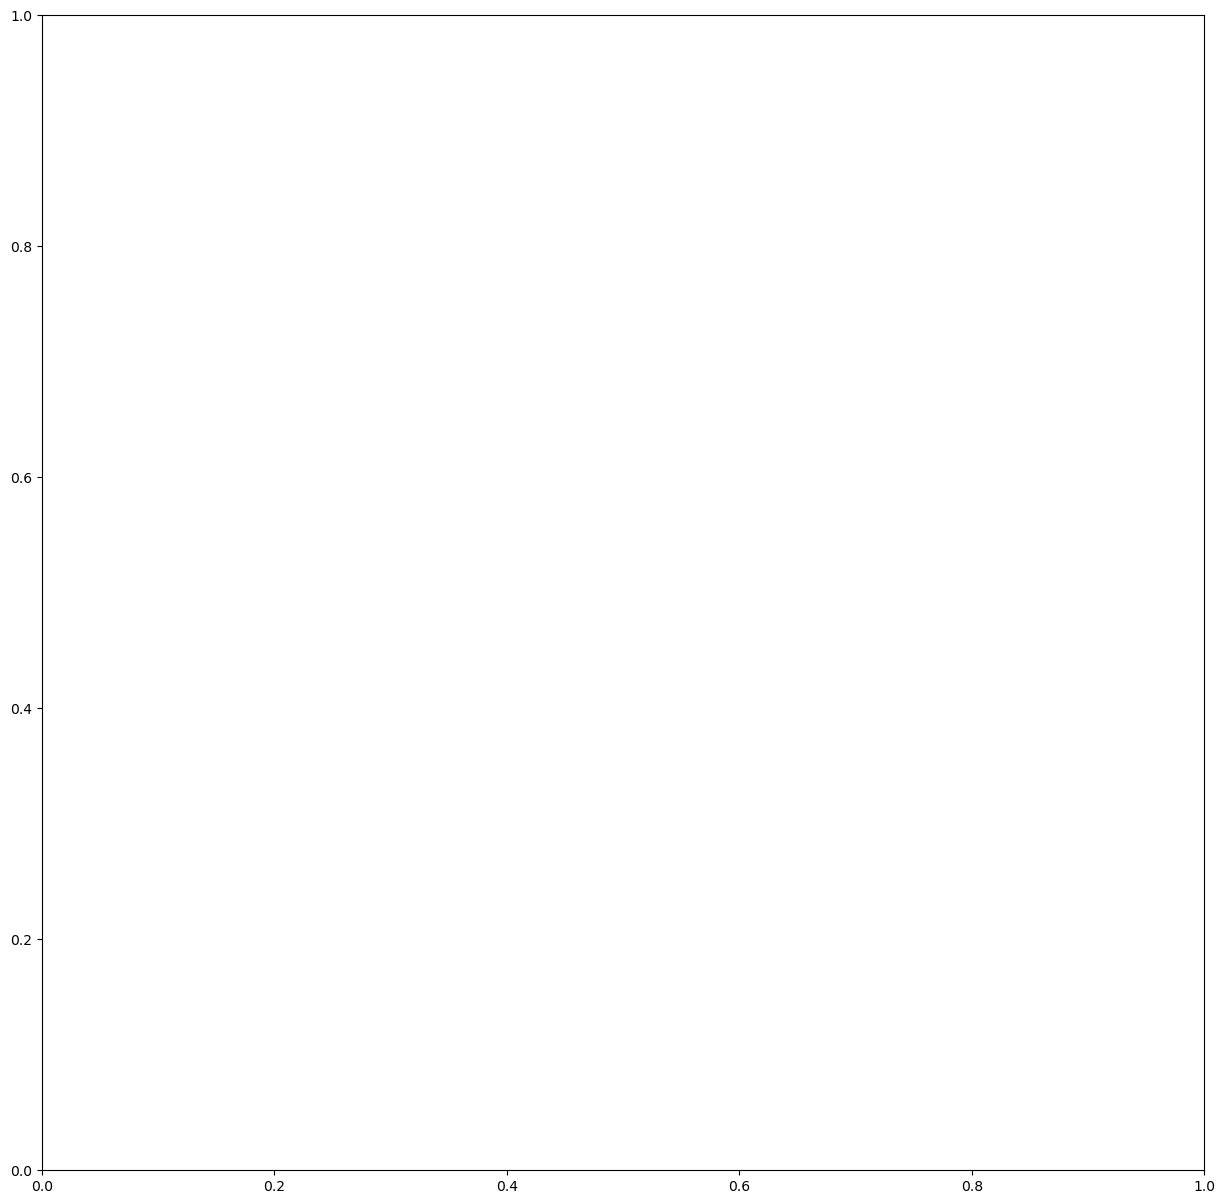

In [521]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px
fig,ax = plt.subplots(figsize=(15,15))

df2.plot(ax=ax,
        column='park_compare_med_read', # this defines the field to "choropleth"
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r', # the "_r" reverses the color
        scheme='quantiles')

ax.axis('off')
ax.set_title('2022 July to January 2023 arrests per 1000 people',fontsize=18,pad=20)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [483]:
df2 = listings_tracts.merge(df, on='fip')
df2.sample(2)

,urls,price,description,lat,long,bedrooms,bathrooms,sqft,park_TF,park_T_why,...,median_rent_PM,medain_rent_PNM,average_rent_PM,average_rent_PNM,geometry_y,park_compare_med,park_compare_average,n_park_compare_med,n_park_compare_average,park_compare_med_read
4723,https://losangeles.craigslist.org/lac/apa/d/lo...,3614.0,lease today at alina in downtown la we are a p...,34.045963,-118.261744,2.0,2.0,1066.0,False,[],...,4515.0,2570.5,4440.833496,2566.089355,"POLYGON ((-118.26038 34.04513, -118.26121 34.0...",-1934,-1779,10.5,95.325928,1934
4802,https://losangeles.craigslist.org/lac/apa/d/lo...,1800.0,e on adams is a brand new luxury community fea...,34.032523,-118.355252,0.0,1.0,449.0,False,[],...,1850.0,1800.0,1785.333374,1700.222168,"POLYGON ((-118.35488 34.02551, -118.35484 34.0...",-50,-77,0.0,7.401001,50
